<a href="https://colab.research.google.com/github/LuisAnibalVasquez/SunSpotPredictor/blob/main/SunSpot_Predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This notebook is part of my professional portfolio

The main goal is to develop a deep learning model that allows predicting the quantity of sun spots using <b>tensorflow</b>. 

To train this model, the "Sunspot2.csv" file was used, which contains information on the number of sunspots from <b>1749</b> to <b>December 2021</b>, said file is stored in my Google Drive. 


In [ ]:
import tensorflow as tf
print(tf.__version__)


2.7.0


In [ ]:
!gdown --id 1pm8kcyw7tm52Sd7Rdyjq91MPJ6KJYU_C

Downloading...
From: https://drive.google.com/uc?id=1pm8kcyw7tm52Sd7Rdyjq91MPJ6KJYU_C
To: /content/Sunspots2.csv
100% 69.7k/69.7k [00:00<00:00, 4.69MB/s]


## Just a simple EDA

In [ ]:
import pandas as pd

archivo = pd.read_csv('Sunspots2.csv')
archivo.head()

,Unnamed: 0,Date,Monthly Mean Total Sunspot Number
0,0,1749-01-31,96.7
1,1,1749-02-28,104.3
2,2,1749-03-31,116.7
3,3,1749-04-30,92.8
4,4,1749-05-31,141.7


In [ ]:
archivo.shape

(3276, 3)

In [ ]:
archivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 3 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Unnamed: 0                         3276 non-null   int64  
 1   Date                               3276 non-null   object 
 2   Monthly Mean Total Sunspot Number  3276 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 76.9+ KB


In [ ]:
archivo.describe()

,Unnamed: 0,Monthly Mean Total Sunspot Number
count,3276.000000,3276.000000
mean,1637.500000,81.609524
std,945.844067,67.844174
min,0.000000,0.000000
25%,818.750000,23.875000
50%,1637.500000,66.850000
75%,2456.250000,122.400000
max,3275.000000,398.200000


In [ ]:
import numpy as np
import csv
import matplotlib.pyplot as plt

time_step = []
sunspots = []

with open('./Sunspots2.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)

print(series)
print(time)

[ 96.7 104.3 116.7 ...  38.1  35.   67.6]
[   0    1    2 ... 3273 3274 3275]


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

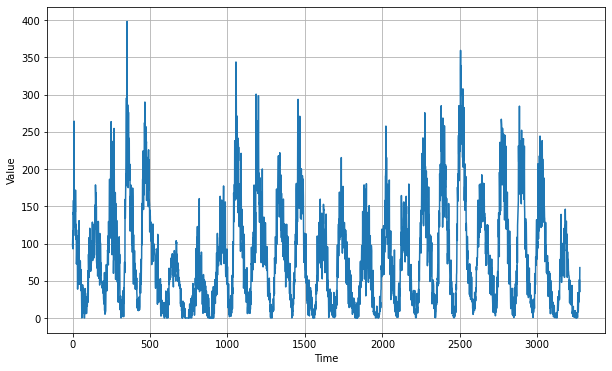

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 64
batch_size = 256
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(64).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(type(dataset))
print(dataset)

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


## Now we create de model and tunning it

The model is based on a set of convolutional, LSTM and Dense layers.

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, 
                         kernel_size=5,
                         strides=1, 
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 400)   
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-10 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-10, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


(1e-09, 0.0001, 0.0, 60.0)

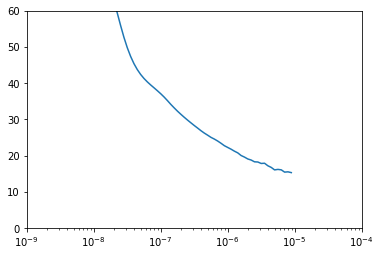

In [ ]:
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=0)
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-9, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

modelF = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, 
                         kernel_size=5,
                         strides=1, 
                         padding="causal",
                         activation="relu",
                         input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1), 
  tf.keras.layers.Lambda(lambda x: x * 400)   
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-5, momentum=0.9)

modelF.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [ ]:
historyF = modelF.fit(dataset, epochs=500)

Epoch 1/500
12/12 [==============================] - 7s 45ms/step - loss: 55.6671 - mae: 56.1652
Epoch 2/500
12/12 [==============================] - 1s 49ms/step - loss: 26.4571 - mae: 26.9514
Epoch 3/500
12/12 [==============================] - 1s 47ms/step - loss: 21.9041 - mae: 22.3979
Epoch 4/500
12/12 [==============================] - 1s 51ms/step - loss: 18.9827 - mae: 19.4751
Epoch 5/500
12/12 [==============================] - 1s 48ms/step - loss: 17.0920 - mae: 17.5837
Epoch 6/500
12/12 [==============================] - 1s 49ms/step - loss: 16.0871 - mae: 16.5782
Epoch 7/500
12/12 [==============================] - 1s 46ms/step - loss: 15.8042 - mae: 16.2952
Epoch 8/500
12/12 [==============================] - 1s 50ms/step - loss: 15.6368 - mae: 16.1277
Epoch 9/500
12/12 [==============================] - 1s 49ms/step - loss: 14.6498 - mae: 15.1401
Epoch 10/500
12/12 [==============================] - 1s 49ms/step - loss: 14.6088 - mae: 15.0992
Epoch 11/500
12/12 [=========

## Now we will predict some values

In [ ]:
rnn_forecast = model_forecast(modelF, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

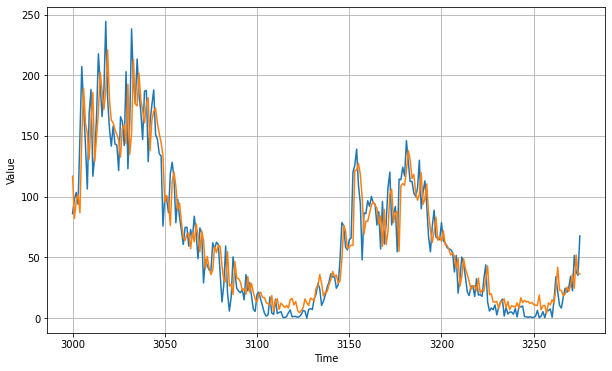

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

14.209959

In [ ]:
print(series[3230:3235])

[ 2.5  8.9 13.1 15.6  1.6]
